**5**. Dive into Deep Learning

Train a deep learning model to classify beetles, cockroaches and dragonflies using these [images](https://www.dropbox.com/s/fn73sj2e6c9rhf6/insects.zip?dl=0). Note: Original images from https://www.insectimages.org/index.cfm. Blog about this, and *explain* how the neural network classified the images using [SHapley Additive exPlanations](https://github.com/slundberg/shap).

If DropBox does not work, you can use this 

`wget https://people.duke.edu/~ccc14/insects.zip`

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd

In [34]:
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Load data

We first read in train set and test set, for simplicity, code below can read images in subdirectories and consider them as category outcome, we also specify batch_size to be 32 which means each batch contains 32 images.

In [35]:
train_ds = image_dataset_from_directory(
    directory='insects/train/',
    labels='inferred', #contain subdirectories, as category outcome
    label_mode='categorical',
    batch_size=32, #each batch contains 32 images
    image_size=(256, 256))
test_ds = image_dataset_from_directory(
    directory='insects/test/',
    labels='inferred',
    label_mode='categorical', 
    batch_size=32,
    image_size=(256, 256))

Found 1019 files belonging to 3 classes.
Found 180 files belonging to 3 classes.


We can see images shown from the train set.

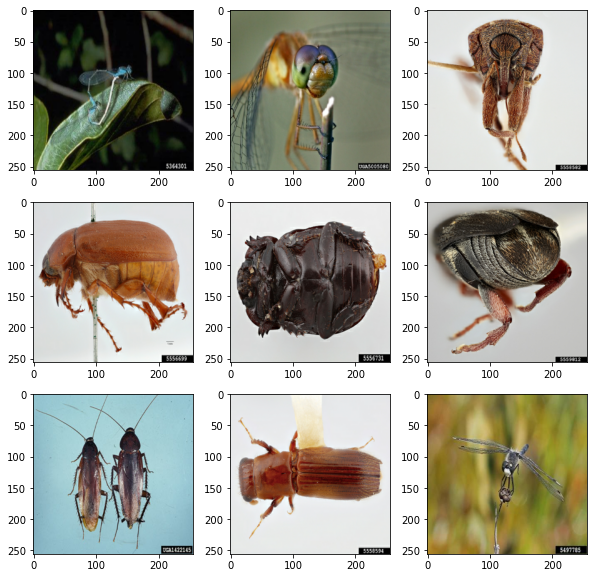

In [36]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) 


To produce more training data based on limited size we have, we can make some changes to original dataset named data_augmentation, including such as horizontal flip mode, rotation and zoom, this helps reduce overfitting as well.

In [44]:
img_height = 256
img_width = 256

In [45]:
data_augmentation = keras.Sequential(
  [layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Model training

1. For input shape of the rescaling: 

- Input_shape is the height, width of the image and RGB 3 channels of the color.

After the first layer, we don't need to specify the size of the input anymore.



2. For convolution parameter:

Different filter will produce different output of an image, such as the darkness of the image, countour of the image and so on, we can comprehend each filter make emphasis on specific characteristic of the image.

- Filter means the total dimensionality of the output space (i.e. the number of filters in the convolution).

- Kernel size means the height and width of the 2D convolution window(which is moving). Can be a single integer to specify the same value for all spatial dimensions, we can specify as 3*3 window by specifying 3.

- Stride is the step of the window is default 1.

- Padding = "same" means we padding with zeros evenly to the left/right or up/down of the input in order to make image length/width divisible by step length of the convolution window. 

- We choose relu activation function for easier training and better performance.

3. MaxPooling can be seen as the resizing of the image, while reduce dimention, it still keeps major important features. Default is 2x2 pooling window.

4. Dropout randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process to avoid overfitting, we can set it to 0.2.

5. Flatten is used after convolution, to make inputs from more than 2 dimensional matrix to 2 dimension.

6. Dense specifies units = dimensionality of the output space.

In [46]:
num_classes =3

In [47]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Since we have 3 categories(more than 2), we can use specify CategoricalCrossentropy as loss function, label represented by float numbers.

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Then we train our model, we specify epochs to be 20 because passing the whole training data only one time is not enough, we have to update weights several times, since each batch has 32 images, we have 32 batches since whole train set has 1019 files (1019/32=31.8).

In [49]:
epochs=25
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/25
32/32 [==============================] - 26s 794ms/step - loss: 1.5053 - accuracy: 0.5957 - val_loss: 0.8296 - val_accuracy: 0.7500
Epoch 2/25
32/32 [==============================] - 25s 777ms/step - loss: 0.5667 - accuracy: 0.7949 - val_loss: 0.7370 - val_accuracy: 0.7667
Epoch 3/25
32/32 [==============================] - 25s 792ms/step - loss: 0.4449 - accuracy: 0.8283 - val_loss: 0.5624 - val_accuracy: 0.7667
Epoch 4/25
32/32 [==============================] - 25s 787ms/step - loss: 0.3894 - accuracy: 0.8528 - val_loss: 0.6291 - val_accuracy: 0.7667
Epoch 5/25
32/32 [==============================] - 25s 789ms/step - loss: 0.4254 - accuracy: 0.8381 - val_loss: 0.4697 - val_accuracy: 0.8556
Epoch 6/25
32/32 [==============================] - 25s 766ms/step - loss: 0.3727 - accuracy: 0.8567 - val_loss: 0.4566 - val_accuracy: 0.8500
Epoch 7/25
32/32 [==============================] - 25s 765ms/step - loss: 0.3407 - accuracy: 0.8685 - val_loss: 0.4228 - val_accuracy: 0.8444

## Model Evaluation and Prediction

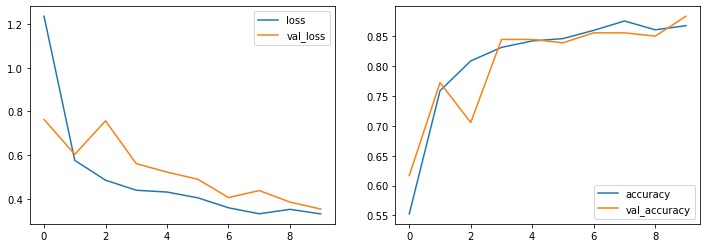

In [32]:
fig, axes = plt.subplots(1,2,figsize=(12, 4))
for ax, measure in zip(axes, ['loss', 'accuracy']):
    ax.plot(history.history[measure], label=measure)
    ax.plot(history.history['val_' + measure], label='val_' + measure)
    ax.legend()
pass

We see the loss is decreasing and accuracy is increasing as epoch increases. The loss and accuracy of test set is orange line, slightly worse than the blue line but there is no huge discrepancy.

We can test one image from the dragonfly category, the prediction score is shown below.

In [16]:
image_size = (256,256)

In [101]:
img = keras.preprocessing.image.load_img("Insects/test/dragonflies/5402448.jpg", 
                                         target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
img_array.shape

TensorShape([1, 256, 256, 3])

In [102]:
predictions = model.predict(img_array)
predictions 

array([[-14.281167 ,  -1.3540096,   9.495153 ]], dtype=float32)

We observe the 9.27 is the highest score, which indicates image 5402448.jpg is a dragonfly.

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

From the below plots, we see the output pixels of the images about the 3 classes. Red pixels increase the model output to be one class while blue pixels decrease the output.

In [50]:
X_train = np.concatenate([x for x, y in train_ds], axis=0)
y_train = np.concatenate([y for x, y in train_ds], axis=0)

In [55]:
X_test = np.concatenate([x for x, y in test_ds], axis=0)
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [52]:
import shap

In [53]:
explainer = shap.GradientExplainer(model, X_train)

In [96]:
sv = explainer.shap_values(X_test[175:180]);

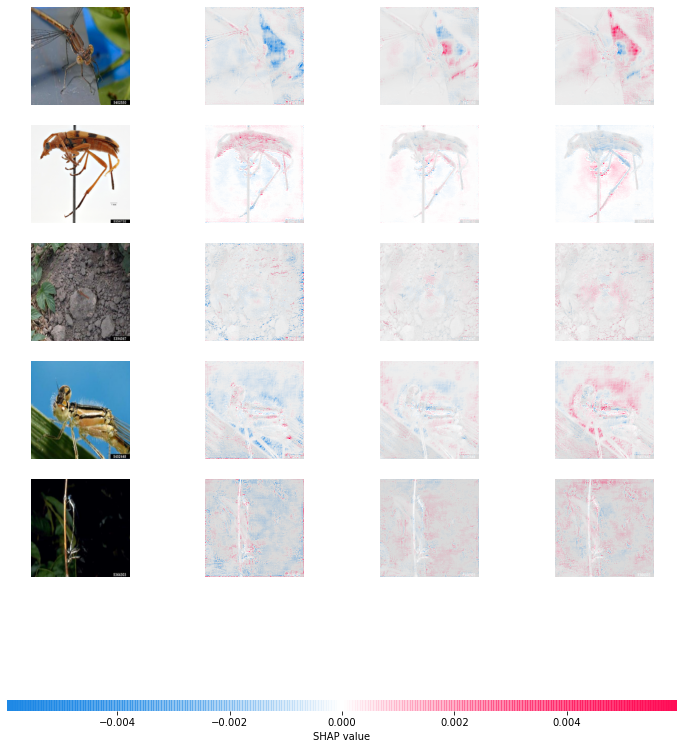

In [98]:
shap.image_plot([sv[i] for i in range(len(sv))], X_test[175:180])

Take the fourth image as an example, we have already checked from the prediction that this is a dragonfly, and from a direct look it is a dragonfly as well. Based on the plots in the fourth line, we see the third one has most redness compared to others, where there are activations indicating how the CNN distinguishes between these outcomes.